In [1]:
import numpy as np
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle, os, time, IPython

from IPython.display import Audio
import librosa as lr
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

/home/alex/licenta/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
rate = 22050
seq_size = 6000

layers = 10
residual_channels = 32
dilation_channels = 32
skip_channels = 128
classes = 256

# receptive_field = 1024 -1
# output_length = 30
# input_length = receptive_field + output_length

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# citeste in memorie fisierele audio salvate anterior
start_time = time.time()
with open('song_list.bin', 'rb') as file:
    songs = pickle.load(file)

print("read %i files in %s seconds" %(len(songs), time.time() - start_time))

read 90 files in 1.137075424194336 seconds


In [5]:
def encode_muLaw(wave, u):  
    ret_wave = u/2+np.sign(wave)*np.log(1 + u*np.abs(wave))/np.log(1 + u)*u/2
    ret_wave = ret_wave.astype(int)
    return ret_wave

def decode_muLaw(wave, u):
    wave = (wave-u/2)*2/u
    ret_wave = np.sign(wave) * (1/u) * ((1+u)**np.abs(wave)-1)
    return ret_wave

def data_generation(data, framerate = rate, seq_size = 6000, mu=256):
    while True:
        idx = np.random.randint(0, len(data))
        song_frames = data[idx][0].shape[0]
        start = np.random.randint(0, song_frames-seq_size)
        ys = data[idx][0][start:start+seq_size]
        ys = encode_muLaw(ys, mu)
        yield ys

In [6]:
train_split = int(len(songs)*0.8)
train_generator = data_generation(songs[:train_split])
valid_generator = data_generation(songs[train_split:])

In [7]:
X = next(train_generator)
X, X.shape, X.max()

(array([200, 202, 203, ..., 179, 182, 184]), (6000,), 211)

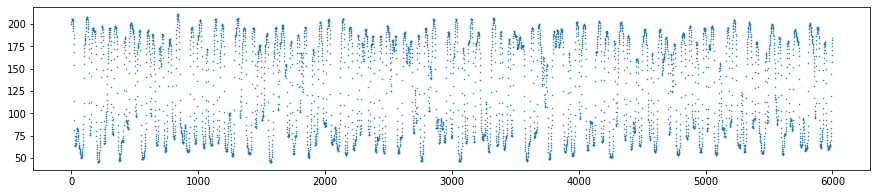

In [8]:
plt.figure(figsize=[15,3])
plt.plot(X,'.', ms=1)

In [10]:
IPython.display.display(Audio(data = X, rate = 22050))

In [11]:
y = decode_muLaw(X, 256)

In [12]:
IPython.display.display(Audio(data = y, rate = 22050))

In [13]:
class wavenet(nn.Module):
    def __init__(self, layers=10, residual_channels=32, dilation_channels = 32, skip_channels=256, classes=256):
        super(wavenet, self).__init__()
        
        self.layers, self.residual_channels, self.dilation_channels, self.skip_channels, self.classes = \
            layers, residual_channels, dilation_channels, skip_channels, classes
        
#         self.num_blocks = 10                 # nr de residual blocks
#         self.dilation_channels = 32          # nr out channels pentru convolutiile din gate si filter
#         self.residual_channels = 32          # nr out channels pt convolutia 1x1 residuala
#         self.skip_channels = 128             # nr out channels pt convolutia 1x1 pt skip layers
#         self.classes = 256 
#         self.skip_layers = [] 
        
   
        self.gate_conv = nn.ModuleList()
        self.filter_conv = nn.ModuleList()
        self.skip_conv = nn.ModuleList()
        self.res_conv = nn.ModuleList()
        
        # definire toate layere de convolutie folosite
        self.first_conv = nn.Conv1d(self.classes, self.residual_channels, 1, dilation = 1)
        self.conv1 = nn.Conv1d(self.skip_channels, self.classes, 1) 
        self.conv2 = nn.Conv1d(self.classes, self.classes, 1)
        dilation = 1
        for i in range(self.layers):
            self.gate_conv.append(nn.Conv1d(self.residual_channels, self.dilation_channels, 2, dilation = dilation))
            self.filter_conv.append(nn.Conv1d(self.residual_channels, self.dilation_channels, 2, dilation = dilation))
            
            self.skip_conv.append(nn.Conv1d(self.dilation_channels, self.skip_channels, 1))
            self.res_conv.append(nn.Conv1d(self.dilation_channels, self.residual_channels, 1))
                               
            dilation *= 2
        
        self.receptive_field = dilation
    
    
    def forward(self, x):
        x = F.one_hot(torch.tensor(x), self.classes).transpose(0,1).unsqueeze(0).float().to(device)
        
        self.skip_layers = []
        x = self.first_conv(x)
        for i in range(self.layers):
            gate = torch.sigmoid(self.gate_conv[i](x))
            filt = torch.tanh(self.filter_conv[i](x))
            prod = gate * filt
            skip = self.skip_conv[i](prod)
            self.skip_layers.append(skip)
            
            res = self.res_conv[i](prod)
            
            # din cauza conv cu kernel >= 2 si dilation >= 1 dim lui "res" se schimba
            # asa iau mai putin din "x" ca sa fac adunarea
            res = x[:,:,-res.shape[2]:] + res  
            x = self.res_conv[i](res)
        
            
        # adunare skip layers
        res = self.skip_layers[self.layers-1]
        l = self.skip_layers[self.layers-1].shape[2]
        for i in range(self.layers-2,0,-1):
            # conv => dim diferite
            # asa iau mai putin din layer-ul curent pentru a face adunarea
            res += self.skip_layers[i][:,:,-l:]
            
        res = F.leaky_relu(res)
        res = F.leaky_relu(self.conv1(res))
        res = self.conv2(res)
        
        # transpose din [batch_size, channels, length] -> [batch_size, length, channels] 
        # pt a obtine softmax de 256(channels) pt fiecare data input
        # res = F.softmax(torch.transpose(res, 1, 2), 2)
        res = torch.transpose(res, 1, 2)
        return res
                
        

In [14]:
learning_rate = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = wavenet().to(device)
receptive_field = model.receptive_field
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [15]:
train_loss = []
valid_loss = []
epoch = 25
classes = 256

start_time = time.time()
for i in range(epoch):
    total_loss = 0.0
    model.train()
    
    with torch.set_grad_enabled(True):
        for j in range(train_split):
            song = next(train_generator)
            target = song[receptive_field:]
            target = torch.tensor(target).to(device)


            optimizer.zero_grad()
            output = model(song[:-1])

            loss = loss_func(output.squeeze(), target.squeeze())
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            print("{} from {}. loss = {}".format(j, train_split, loss.data), end = "\r")
        
        
    total_val_loss = 0.0
    with torch.no_grad():
        model.eval()
        n = len(songs)-train_split
        for j in range(n):
            song = next(valid_generator)
            target = song[receptive_field:]
            target = torch.tensor(target).to(device)
            
            output = model(song[:-1])
            loss = loss_func(output.squeeze(), target.squeeze())

            total_val_loss += loss.data
            
        print("Validation loss = {}".format(total_val_loss/n), end="\r")

#     print("Epoch: {}".format(i+1))

    train_loss.append(total_loss/train_split)
    valid_loss.append(total_val_loss/n)
    print("Epoch {}, train={:.4f}, valid={:.4f}; in {:.2f} seconds".format(i+1, train_loss[-1], valid_loss[-1], time.time() - start_time))

Epoch 1, train=5.2356, valid=4.8975; in 3.28 seconds
Epoch 2, train=4.3103, valid=4.4474; in 6.52 seconds
Epoch 3, train=3.9268, valid=3.4069; in 9.77 seconds
Epoch 4, train=3.4747, valid=2.7574; in 13.23 seconds
Epoch 5, train=3.2274, valid=2.9473; in 16.63 seconds
Epoch 6, train=3.0691, valid=2.6873; in 20.07 seconds
Epoch 7, train=2.7632, valid=2.6074; in 23.47 seconds
Epoch 8, train=3.1439, valid=2.8805; in 26.65 seconds
Epoch 9, train=3.0957, valid=2.4105; in 30.16 seconds
Epoch 10, train=2.7229, valid=2.5201; in 33.68 seconds
Epoch 11, train=2.7942, valid=2.5222; in 36.95 seconds
Epoch 12, train=2.7002, valid=2.5462; in 39.97 seconds
Epoch 13, train=2.5167, valid=2.1942; in 43.35 seconds
Epoch 14, train=2.4615, valid=2.1409; in 46.80 seconds
Epoch 15, train=2.4389, valid=2.2120; in 50.29 seconds
Epoch 16, train=2.5564, valid=2.1988; in 53.67 seconds
Epoch 17, train=2.5275, valid=2.1283; in 57.13 seconds
Epoch 18, train=2.5764, valid=2.0905; in 60.70 seconds
Epoch 19, train=2.4298

In [74]:
# g = list((np.random.rand(20000)*256).astype(int))
g = encode_muLaw(songs[0][0][30000:120000], 256)
output = model(g[:-1])
output = output.argmax(2)[0].cpu()

In [75]:
y = decode_muLaw(output, 256)

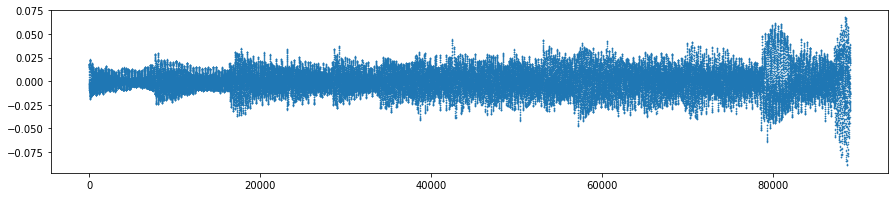

In [76]:
plt.figure(figsize=[15,3])
plt.plot(songs[0][0][1024+30000:120000],'.', ms=1)

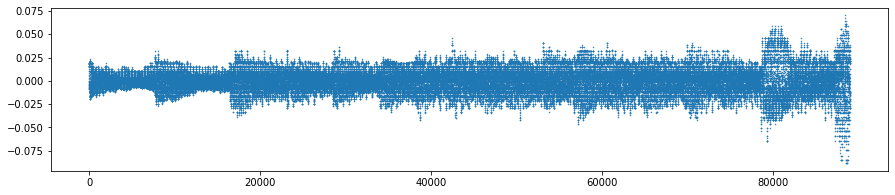

In [77]:
plt.figure(figsize=[15,3])
plt.plot(y,'.', ms=1)

In [78]:
IPython.display.display(Audio(data = songs[0][0][30000+1024:120000], rate = 22050))

In [79]:
IPython.display.display(Audio(data = y, rate = 22050))

In [60]:
y.min(), y.max()

(tensor(-0.4561), tensor(0.4366))

saveVar(songs, "song_list.bin")

In [ ]:
with h5py.File('data.h5', 'r') as hdf:
    ls = list(hdf.keys())
    x = np.array(hdf.get("x"))
    y = np.array(hdf.get("y"))   

In [ ]:
train_loader = torch.utils.data.DataLoader(list(zip(x[:4500],y[:4500])), batch_size=1, shuffle=True, num_workers = 1)
valid_loader = torch.utils.data.DataLoader(list(zip(x[4500:],y[4500:])), batch_size=1, shuffle=True, num_workers = 1)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()        
        
        self.first_conv = nn.Conv1d(1, 128, 1)
        self.last_conv = nn.Conv1d(128, 128, 1)
        self.avg_pooling = nn.AvgPool1d(2)
        self.module_list = nn.ModuleList() 
        for i in range(10):
            self.module_list.append(nn.Conv1d(128,128,3))
            self.module_list.append(nn.Conv1d(128,128,1))
        
        
    def forward(self, x):
        res = self.first_conv(x)
        x = res
        for i in range(0,20,2):
            x = F.leaky_relu(x)
            x = F.leaky_relu(self.module_list[i](x))
            x = self.module_list[i+1](x)
            res = torch.add(nn.Conv1d(128,128,3)(res), x)   
            x = res
            
        x = self.last_conv(x)
        x = self.avg_pooling(x)
        return x  

In [ ]:
model = Encoder()

In [ ]:
x = torch.randn([1,1,100])
y = model(x)

In [ ]:
learning_rate = 0.01
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = wavenet().to(device)
receptive_field = model.receptive_field
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
train_loss = []
valid_loss = []
epoch = 5
classes = 256

for i in range(epoch):
    total_loss = 0.0
    total_iter = 0
    model.train()
    
    step = 0
    with torch.set_grad_enabled(True):
        for song,target in train_loader:
            step += 1

            # new shape (batch_size, num_classes, length_item)
            song = torch.transpose(song, 1, 2).to(device).float()
            target = target.to(device)


            optimizer.zero_grad()
            output = model(song)
    #         output = Variable(output, requires_grad = True) # fara asta nu merge backward, cu el raman fara memorie
    #         print("song: {}, output: {}, target: {}".format(song.shape, output.squeeze().shape, target.squeeze().shape ))

            loss = loss_func(output.squeeze(), target.squeeze())
            loss.backward()
            optimizer.step()

            total_iter += 1
            total_loss += loss.data

            print("{} din {} iteratii. loss = {}".format(step, 4500, loss.data), end = "\r")
        
        
    total_val_loss = 0.0
    total_val_iter = 0
    with torch.no_grad():
        model.eval()
        for song, target in valid_loader:
            
            song = torch.transpose(song, 1, 2).to(device).float()
            target = target.to(device)
            
            output = model(song)
            loss = loss_func(output.squeeze(), target.squeeze())

            total_val_loss = loss.data
            total_val_iter += 1 

        print("Validation loss = {}".format(total_val_loss/total_val_iter))

    print("epoca: {}".format(i+1))

    train_loss.append(total_loss / total_iter)
    valid_loss.append(total_val_loss/ total_val_iter)

In [ ]:
samples=0
target_samples = 100000
song = np.array([])
input = x[0]
classes = 256
process = input
while(samples <= target_samples-samples):
    if(samples != 0):
        process = encode_muLaw(input, classes)
        quantized = quantize_data(process, classes)
        process = one_hot(quantized, classes, 'float')
    process = torch.from_numpy(process).unsqueeze(0)
    process = torch.transpose(process, 1, 2).to(device).float()
    pred = model(process)
    
    length = pred.shape[1]
    
   
    samples += length

    pred_processed = []
    softmax = F.softmax(pred, 2)
    for i in range(pred.shape[1]):
        pred_processed.append(softmax[:,i,:].argmax())

    
    bins = np.linspace(-1, 1, classes)
    quantized = [bins[i] for i in pred_processed]
    mu_x = decode_muLaw(quantized, classes)
  
    song = np.append(song, mu_x)
    
    
    if(samples == length):
        input = np.concatenate((np.zeros(receptive_field),mu_x))
    input = np.concatenate((input[-receptive_field:], mu_x))
    print("{}/{}...{}".format(samples, target_samples, input.shape), end = "\r")


In [ ]:
IPython.display.display(Audio(data = song, rate = 22050))

In [ ]:
def readVar(fileName):
    with open(fileName, 'rb') as file:
        return pickle.load(file)
    
def saveVar(v, fileName):
    with open(fileName, 'wb') as file:
        pickle.dump(v, file)
        
def encode_muLaw(wave, u):  
    # input must be: -1 < wave[i] < 1 
    l = len(wave)
    ret_wave = np.zeros(l)
    for i in range(l):
        ret_wave[i] = np.sign(wave[i])*np.log(1 + u*np.abs(wave[i]))/np.log(1 + u)
    return ret_wave

def decode_muLaw(wave, u):
    # input must be: -1 < wave[i] < 1
    l = len(wave)
    ret_wave = np.zeros(l)
    for i in range(l):
        ret_wave[i] = np.sign(wave[i]) * (1/u) * ((1+u)**np.abs(wave[i]) -1)

    return ret_wave

def one_hot(wave, classes, type):

    res = np.zeros((wave.shape[-1], classes))
    for i, el in enumerate(wave):
        res[i,int(el)] = 1
    return res

def quantize_data(data, classes):
    mu_x = encode_muLaw(data, classes)
    bins = np.linspace(-1, 1, classes)
    quantized = np.digitize(mu_x, bins) - 1
    return quantized